In [3]:
import torch
import torch.nn as nn

import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import sys
sys.path.append('/workspace/experiment')
from data.cifar10 import SplitCifar10, train_transform, val_transform
from data.capsule_split import get_splits

import os

import matplotlib.pyplot as plt


In [4]:
split = get_splits('cifar10', 0)
known_data = SplitCifar10('/datasets', train=False, transform=val_transform, split=split['known_classes'])
open_data = SplitCifar10('/datasets', train=False, transform=val_transform, split=split['unknown_classes'])
known_loader = DataLoader(known_data, batch_size=32, shuffle=False, num_workers=4)
open_loader = DataLoader(open_data, batch_size=32, shuffle=False, num_workers=4)
test_input, test_target = next(iter(known_loader))

In [8]:
path = './noise_analyze/split0.ckpt'

In [9]:
state_dict= torch.load(path)

In [13]:
class NoiseEncoder(nn.Module):
    def __init__(self, 
                 channel_in:  int, 
                 channel_out: int, 
                 kernel_size: int, 
                 stride:      int, 
                 padding:     int, 
                 bias:        bool=False, 
                 num_classes: int=6,
                 alpha: float=1.0):
        
        super(self.__class__, self).__init__()
        self.conv = nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=bias)
        self.bn = nn.BatchNorm2d(channel_out)
        self.bn_noise = nn.BatchNorm2d(channel_out)
        self.activation = nn.LeakyReLU(0.2)
        self.num_classes = num_classes
        self.register_buffer('buffer', None)
        self.alpha = alpha
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x
    
    def forward_clean(self, x, class_mask):
        x = self.conv(x)
        self.cal_class_per_std(x, class_mask)
        x = self.bn(x)
        x = self.activation(x)
        return x
        
    def forward_noise(self, x, newY):
        x = self.conv(x)
        x = x + self.alpha * torch.normal(mean=0, std=self.buffer[newY]).type_as(x)
        x = self.bn_noise(x)
        x = self.activation(x)
        return x
    
    def cal_class_per_std(self, x, idxs):
        std = []
        for i in range(self.num_classes):
            x_ = x[idxs[i]].detach().clone()
            
            std.append(x_.std(0))
        self.buffer = torch.stack(std)

class Noiseclassifier32(nn.Module):
    def __init__(self, 
                 num_classes: int=6,
                 alpha: int=1.0,
                 **kwargs):
        super(self.__class__, self).__init__()
        self.num_classes = num_classes
        
        self.conv1 = NoiseEncoder(3,     64,    3, 1, 1, bias=False, num_classes=num_classes)
        self.conv2 = NoiseEncoder(64,    64,    3, 1, 1, bias=False, num_classes=num_classes)
        self.conv3 = NoiseEncoder(64,   128,    3, 2, 1, bias=False, num_classes=num_classes)
        
        self.conv4 = NoiseEncoder(128,  128,    3, 1, 1, bias=False, num_classes=num_classes)
        self.conv5 = NoiseEncoder(128,  128,    3, 1, 1, bias=False, num_classes=num_classes)
        self.conv6 = NoiseEncoder(128,  128,    3, 2, 1, bias=False, num_classes=num_classes)
        
        self.conv7 = NoiseEncoder(128,  128,    3, 1, 1, bias=False, num_classes=num_classes)
        self.conv8 = NoiseEncoder(128,  128,    3, 1, 1, bias=False, num_classes=num_classes)
        self.conv9 = NoiseEncoder(128,  128,    3, 2, 1, bias=False, num_classes=num_classes)
        
        self.fc = nn.Linear(128, num_classes)
        self.dr1 = nn.Dropout2d(0.2)
        self.dr2 = nn.Dropout2d(0.2)
        self.dr3 = nn.Dropout2d(0.2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.apply(self.weights_init)
        
        
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.05)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

    def forward(self, x):
        batch_size = len(x)
        x = self.dr1(x)
        x = self.conv1(x)
        
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = self.dr2(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        
        x = self.dr3(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        
        logit = self.fc(x)
        
        return logit
    
    def forward_clean(self, x, y):
        batch_size = len(x)
        class_mask = y.unsqueeze(0) == torch.arange(self.num_classes).type_as(y).unsqueeze(1)
        x = self.dr1(x)
        x = self.conv1.forward_clean(x, class_mask)
        x = self.conv2.forward_clean(x, class_mask)
        x = self.conv3.forward_clean(x, class_mask)
        
        x = self.dr2(x)
        x = self.conv4.forward_clean(x, class_mask)
        x = self.conv5.forward_clean(x, class_mask)
        x = self.conv6.forward_clean(x, class_mask)
        
        x = self.dr3(x)
        x = self.conv7.forward_clean(x, class_mask)
        x = self.conv8.forward_clean(x, class_mask)
        x = self.conv9.forward_clean(x, class_mask)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        
        logit = self.fc(x)
        
        return {
            "logit": logit,
            "emb": x
        }
    
    def forward_noise(self, x, y, noise_layer=[]):
        batch_size = len(x)
        newY = self.cal_index(y)
        
        x = self.dr1(x)
        x = self.conv1.forward_noise(x, newY)
        x = self.conv2.forward_noise(x, newY)
        x = self.conv3.forward_noise(x, newY)
        
        x = self.dr2(x)
        x = self.conv4.forward_noise(x, newY)
        x = self.conv5.forward_noise(x, newY)
        x = self.conv6.forward_noise(x, newY)
        
        x = self.dr3(x)
        x = self.conv7.forward_noise(x, newY)
        x = self.conv8.forward_noise(x, newY)
        x = self.conv9.forward_noise(x, newY)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        
        logit = self.fc(x)
        
        return {
            'logit': logit,
            'newY': newY,
            'emb': x
        }
        
    def cal_index(self, y):
        batch_size = y.size(0)
        new_index = torch.randperm(batch_size).type_as(y)
        newY = y[new_index]
        mask = (newY == y)
        while mask.any().item():
            newY[mask] = torch.randint(0, self.num_classes, (torch.sum(mask),)).type_as(y)
            mask = (newY == y)
        return newY

In [14]:
model = Noiseclassifier32(num_classes=6, alpha=0.1)
model_state_dict = model.state_dict()
for name, param in state_dict['state_dict'].items():
    n = name.replace('model.', '')
    if n in model_state_dict.keys():
        model_state_dict[n].copy_(param)

In [15]:
out = model(test_input)

tensor([[9.9380e-01, 1.0275e-03, 4.9737e-03, 4.5723e-05, 5.0575e-05, 1.0652e-04],
        [9.1439e-08, 9.9995e-01, 7.9514e-08, 3.6096e-09, 3.6979e-08, 5.2403e-05],
        [5.1370e-07, 1.0000e+00, 4.4065e-10, 8.4260e-09, 3.4184e-10, 1.9184e-06],
        [9.9990e-01, 2.4026e-07, 9.9161e-07, 1.6055e-06, 9.6988e-05, 5.3044e-08],
        [1.1869e-07, 3.8635e-04, 1.3713e-09, 1.7372e-11, 1.0366e-10, 9.9961e-01],
        [4.0513e-09, 3.6991e-08, 1.7865e-06, 1.8733e-03, 9.9812e-01, 1.5542e-10],
        [1.1949e-05, 1.5779e-04, 7.1154e-08, 1.6280e-08, 1.2706e-08, 9.9983e-01],
        [4.6475e-06, 5.1561e-05, 2.6979e-04, 1.3843e-05, 9.9965e-01, 9.2800e-06],
        [2.6272e-01, 5.1763e-07, 7.3727e-01, 1.9929e-07, 7.6255e-06, 4.3029e-06],
        [9.1914e-05, 2.2915e-08, 1.0490e-03, 9.9886e-01, 1.6760e-06, 3.6650e-08],
        [1.0511e-08, 3.3112e-06, 1.2846e-10, 6.1905e-13, 2.5557e-11, 1.0000e+00],
        [1.0494e-02, 1.1434e-03, 1.9908e-01, 3.4061e-01, 4.4468e-01, 3.9891e-03],
        [5.9301e

In [21]:
oInput, oTarget = next(iter(open_loader))

In [22]:
oOut = model(oInput)

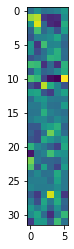

In [28]:
plt.imshow(oOut.detach().numpy())

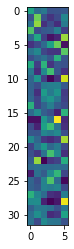

In [29]:
plt.imshow(out.detach().numpy())

In [31]:
clean_out = model.forward_clean(test_input, test_target)

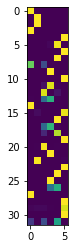

In [36]:
plt.imshow(clean_out['logit'].softmax(-1).detach().numpy())

In [37]:
noise_out = model.forward_noise(test_input, test_target)

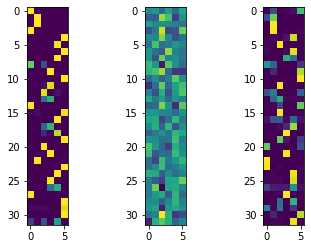

In [54]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(clean_out['logit'].softmax(-1).detach().numpy())
ax[1].imshow(noise_out['logit'].softmax(-1).detach().numpy())
ax[2].imshow(oOut.softmax(-1).detach().numpy())

# plt.imshow(noise_out['logit'].softmax(-1).detach().numpy())

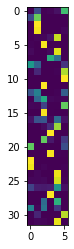

In [53]:
plt.imshow(oOut.softmax(-1).detach().numpy())

IndexError: too many indices for tensor of dimension 2

In [43]:
oOut

tensor([[ -1.8296,   1.6764,  -1.7195,  -1.0388,   0.0491,   2.7916],
        [ 11.4815,  12.7230,  -7.6770,  -8.9519,  -8.6785,   1.4800],
        [  2.6099,  14.3746,  -2.7323,  -8.8380,  -9.7765,   5.1443],
        [ -3.1441,   7.4301,  -2.5380,  -0.0564,  -5.0438,   3.4383],
        [ -4.6795,   0.1210,   0.3731,   1.4600,   4.2965,  -1.7956],
        [  2.5295,  -7.8531,   7.1973,   0.4706,   0.5985,  -2.9122],
        [  1.9588,  -5.6569,  -1.8375,   1.9293,   5.6156,  -2.0883],
        [ -4.8118,  -2.7645,  -1.3342,   5.8823,   5.3363,  -2.4248],
        [  7.1005,   6.5607,  -8.2463,  -2.6730,  -8.3546,   5.8198],
        [ -3.8233,   3.1443,  -3.2673,  -2.1838,   0.8429,   5.2085],
        [  8.0845,   6.2785,  -6.3844, -11.2007, -12.1910,  15.7805],
        [ -5.2448,  -8.1294,  12.9348,   5.1633,   0.3781,  -5.2574],
        [  3.6757,   4.2031,  -4.6753,  -7.2367,   0.4505,   3.8205],
        [ -2.2204,   2.0621,   2.6850,  -0.5848,  -1.0365,  -0.9096],
        [ -0.6542,  